In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from tqdm import tqdm

from tensorflow.keras import Model
from PIL import Image

In [2]:
def dataLoader(root_dir):
    fnames = os.listdir(root_dir)
    data = np.zeros([len(fnames), 224, 224, 3])
    for i in tqdm(range(len(fnames)), ncols=70):
        fname = fnames[i]
        path = os.path.join(root_dir, fname)
        data[i, :, :, :] = cv2.resize(cv2.imread(path), (224, 224)) / 255.0
    data = data.astype(np.float32)
    
    return data

def gram_matrix(input_tensor):
    '''
        Sum_{i, j}(F_{bijc} * F_{bijd})
    G = -------------------------------,   b = batch,  i,j = position,  c,d = feature maps generating from different filters
                    I * J
    '''
    temp = tf.linalg.einsum('bijc, bijd -> bcd', input_tensor, input_tensor)
    numer = tf.expand_dims(temp, axis=0) if len(temp.shape) < 3 else temp
    input_shape = input_tensor.shape
    denom = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    return numer / denom

In [3]:
class StyleTransferNet:
    def __init__(self, content_weight=1e-1, style_weight=1e-6, 
                 content_image=None, style_image=None, 
                 opt=tf.optimizers.Adam(learning_rate=0.003)):
        
        # build the network
        vgg19 = tf.keras.applications.VGG19(include_top=True, weights=None)
        vgg19.load_weights('./vgg19_weights_tf_dim_ordering_tf_kernels.h5')
        vgg19.trainable = False
        content_layers = ['block4_conv2']
        style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
        content_output = vgg19.get_layer(content_layers[0]).output
        style_output = [vgg19.get_layer(style_layer).output for style_layer in style_layers]
        gram_style_output = [gram_matrix(output_) for output_ in style_output]
        self.model = Model([vgg19.input], [content_output, gram_style_output])
        
        
        # load the images and params
        self.content_image = content_image
        self.style_image = style_image
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.content_target = self.model(np.array(self.content_image * 255))[0]
        self.style_target = self.model(np.array([self.style_image * 255]))[1]
        
        # optimizer
        self.opt = tf.optimizers.Adam(learning_rate=0.003, beta_1=0.99, epsilon=1e-1)
        
        # initializing the losses
        self.losses = []
        
        
    def compute_loss(self, style_output, content_output):

        content_loss = tf.reduce_mean((content_output - self.content_target)**2)
        style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_output, self.style_target)])
        loss = self.style_weight * style_loss + self.content_weight * content_loss
        self.losses.append(loss)
        
        return loss
    
    
    def train(self, image, epoch):
        with tf.GradientTape() as tape:
            output = self.model(image * 255)
            loss = self.compute_loss(output[1], output[0])
        gradient = tape.gradient(loss, image)
        self.opt.apply_gradients([(gradient, image)])
        image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

        if epoch % 100 == 0: 
            tf.print(f'Epoch = {epoch}, Loss = {loss}')

100%|███████████████████████████████████| 8/8 [00:00<00:00, 33.99it/s]


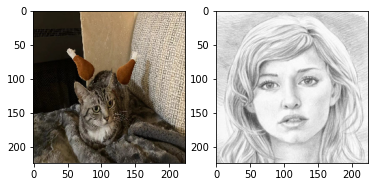

Epoch = 0, Loss = 320649.25
Epoch = 100, Loss = 81938.0703125
Epoch = 200, Loss = 64265.609375
Epoch = 300, Loss = 56065.78125
Epoch = 400, Loss = 51528.125
Epoch = 500, Loss = 48809.22265625
Epoch = 600, Loss = 46996.7109375
Epoch = 700, Loss = 45687.99609375
Epoch = 800, Loss = 44699.3984375
Epoch = 900, Loss = 43892.8125
Training succeeded. Total time cost = 27.87 s


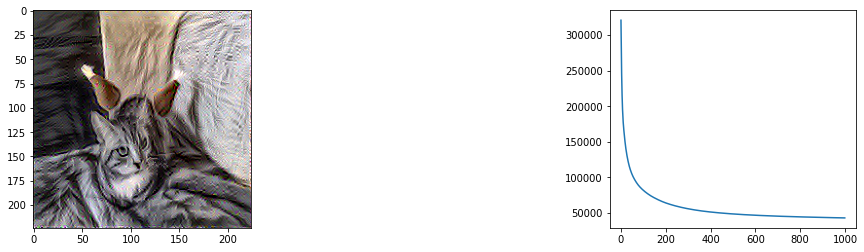

In [4]:
# training data
root_dir = './images'
content_image = dataLoader(root_dir)[3]
if content_image.ndim < 4:
    content_image = tf.expand_dims(content_image, axis=0)

# style reference
style_image = cv2.resize(cv2.imread('./styles/sumiao.png'), (224, 224))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

# visualize content and style
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image[0, :, :, :]), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

# parameters and optimizer
epochs = 1000
batch_size = content_image.shape[0]
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# Model
ST_Model = StyleTransferNet(content_weight=1e-1, style_weight=1e-6, content_image=content_image, style_image=style_image, opt=optimizer)

# variable
image = tf.image.convert_image_dtype(content_image, tf.float32)
if image.ndim < 4: 
    image = tf.Variable([image])
else: image = tf.Variable(image)
    
# train
start = time.time()
for epoch in range(epochs):
    ST_Model.train(image, epoch)
end = time.time()
print(f'Training succeeded. Total time cost = {round((end - start), 2)} s')

# visualization of results
plt.subplots(figsize=(15,4))

for i in range(min(2, content_image.shape[0])):
    tensor = image[i] * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3: 
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    tensor = Image.fromarray(tensor)

    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
    
plt.subplot(1, 3, 3)
plt.plot(ST_Model.losses)
plt.show()